CELL 1 — Imports + seeds

In [2]:
# Operating system utilities
import os

# Array handling
import numpy as np

# Pickle for loading normalization stats
import pickle

# EEG preprocessing libraries
import mne
import pywt

# Machine learning utilities
from sklearn.decomposition import FastICA
from sklearn.metrics import confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras

# Reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Imports loaded and seeds set.")


✅ Imports loaded and seeds set.


CELL 2 — Load trained model + normalization stats

In [4]:
import os
import zipfile
import tempfile
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, SeparableConv2D, DepthwiseConv2D, BatchNormalization, Activation,
    AveragePooling2D, Dropout, Dense, Add, Reshape,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# =========================
# Paths (UPDATED for Parkinson)
# =========================
MODEL_PATH = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Parkinson\model inference\p_eegformer-v1.keras"
MEAN_PATH  = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Parkinson\model inference\p_train_mean.pkl"
STD_PATH   = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Parkinson\model inference\p_train_std.pkl"

# =========================
# Safe replacement for Lambda(lambda y: y[:, :, :, :32])
# =========================
class ChannelSlice(keras.layers.Layer):
    def __init__(self, n_channels, **kwargs):
        super().__init__(**kwargs)
        self.n_channels = n_channels

    def call(self, x):
        return x[:, :, :, :self.n_channels]

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"n_channels": self.n_channels})
        return cfg


# =========================
# Model definition
# =========================
def SpatialAttention(x):
    attention = tf.keras.layers.GlobalAveragePooling2D()(x)
    attention = Dense(64, activation='relu')(attention)
    attention = Dense(x.shape[1], activation='sigmoid')(attention)
    attention = tf.keras.layers.Reshape((x.shape[1], 1, 1))(attention)
    return tf.keras.layers.Multiply()([x, attention])

def TransformerBlock(x, num_heads=4, key_dim=64, ff_dim=128, dropout_rate=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = Add()([x, attn_output])
    attn_output = LayerNormalization()(attn_output)

    ff_output = Dense(ff_dim, activation='relu')(attn_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(x.shape[-1])(ff_output)
    x = Add()([attn_output, ff_output])
    x = LayerNormalization()(x)
    return x

def EEGNet_SpatialTransformer(input_shape=(127, 100, 1), dropout_rate=0.5, num_heads=4, ff_dim=128):
    inputs = Input(shape=input_shape)

    x = SeparableConv2D(32, (1, 5), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SpatialAttention(x)

    x = DepthwiseConv2D((input_shape[0], 1), use_bias=False, depth_multiplier=2, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    residual = ChannelSlice(32, name="residual_slice")(inputs)
    residual = BatchNormalization()(residual)

    x = Add()([x, residual])
    x = BatchNormalization()(x)

    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropout_rate)(x)

    x = SeparableConv2D(64, (1, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropout_rate)(x)

    x_shape = K.int_shape(x)
    x = Reshape((x_shape[1], x_shape[2] * x_shape[3]))(x)
    x = TransformerBlock(x, num_heads=num_heads, key_dim=64, ff_dim=ff_dim)

    x = GlobalAveragePooling1D()(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs, name="EEGNet_SpatialTransformer")


# =========================
# Extract weights from .keras
# =========================
def extract_weights_from_keras(keras_path: str) -> str:
    tmp_dir = tempfile.mkdtemp(prefix="keras_weights_")
    with zipfile.ZipFile(keras_path, "r") as z:
        names = z.namelist()
        weight_candidates = [n for n in names if n.endswith(".h5") and "weights" in n.lower()]
        if not weight_candidates:
            raise FileNotFoundError(f"No weights .h5 found inside {keras_path}")

        weights_name = weight_candidates[0]
        z.extract(weights_name, tmp_dir)
        return os.path.join(tmp_dir, weights_name)


# =========================
# Build & load model
# =========================
model = EEGNet_SpatialTransformer(input_shape=(62, 100, 1))

weights_path = extract_weights_from_keras(MODEL_PATH)
model.load_weights(weights_path)
print("✅ Weights loaded into rebuilt model.")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5)]
)

# =========================
# Load mean / std
# =========================
with open(MEAN_PATH, "rb") as f:
    train_mean = pickle.load(f)
print("✅ Training mean loaded.")

with open(STD_PATH, "rb") as f:
    train_std = pickle.load(f)
print("✅ Training std loaded.")

# =========================
# Save SAFE model (CURRENT WORKING DIRECTORY)
# =========================
SAFE_MODEL_PATH = os.path.join(os.getcwd(), "p_eegformer-v1_SAFE.h5")
model.save(SAFE_MODEL_PATH)
print(f"✅ Saved safe model to: {SAFE_MODEL_PATH}")


✅ Weights loaded into rebuilt model.
✅ Training mean loaded.
✅ Training std loaded.
✅ Saved safe model to: C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Parkinson\model inference\p_eegformer-v1_SAFE.h5


CELL 3 — Load ONLY excluded trials

In [5]:
import numpy as np

# =========================
# Local EEG data paths (UPDATED for Parkinson)
# =========================
NEG_PATH = r"D:\Dermerzel\SomnasNest\Parkinson\Data Array\parkinson_negative.npy"
POS_PATH = r"D:\Dermerzel\SomnasNest\Parkinson\Data Array\parkinson_positive.npy"

# =========================
# Load full arrays
# =========================
X_neg_full = np.load(NEG_PATH).astype(np.float32)
X_pos_full = np.load(POS_PATH).astype(np.float32)

print("✅ EEG arrays loaded.")
print("Negative shape:", X_neg_full.shape)
print("Positive shape:", X_pos_full.shape)

# =========================
# Extract ONLY last 5 trials (excluded during training)
# =========================
X_neg_excluded = X_neg_full[-5:]
X_pos_excluded = X_pos_full[-5:]

print("✅ Extracted excluded trials:")
print("Excluded negative:", X_neg_excluded.shape)
print("Excluded positive:", X_pos_excluded.shape)


✅ EEG arrays loaded.
Negative shape: (31, 62, 120000)
Positive shape: (21, 62, 60000)
✅ Extracted excluded trials:
Excluded negative: (5, 62, 120000)
Excluded positive: (5, 62, 60000)


CELL 4 — Select ONLY last ad_negative sample (target = 0)

In [44]:
# Select ONLY the last excluded positive trial
X_test_trial = X_pos_excluded[-5]        # last unseen ad_positive sample
y_test_trial = 1                         # ground truth label (positive)

print("✅ Selected last excluded ad_positive trial.")
print("Trial shape:", X_test_trial.shape)
print("Ground truth label:", y_test_trial)


✅ Selected last excluded ad_positive trial.
Trial shape: (62, 60000)
Ground truth label: 1


* downsampling

In [45]:
'''# --- Downsample from 1000 Hz -> 500 Hz (keep output name: X_test_trial) ---
sfreq_in = 1000
sfreq_out = 500

X_test_trial = mne.filter.resample(
    X_test_trial.astype(np.float64, copy=False),
    down=sfreq_in // sfreq_out,   # 2
    npad="auto",
    axis=-1,
    verbose=True
).astype(np.float32, copy=False)

print("✅ Downsampled X_test_trial to 500 Hz.")
print("Trial shape after downsampling:", X_test_trial.shape, X_test_trial.dtype)
'''

'# --- Downsample from 1000 Hz -> 500 Hz (keep output name: X_test_trial) ---\nsfreq_in = 1000\nsfreq_out = 500\n\nX_test_trial = mne.filter.resample(\n    X_test_trial.astype(np.float64, copy=False),\n    down=sfreq_in // sfreq_out,   # 2\n    npad="auto",\n    axis=-1,\n    verbose=True\n).astype(np.float32, copy=False)\n\nprint("✅ Downsampled X_test_trial to 500 Hz.")\nprint("Trial shape after downsampling:", X_test_trial.shape, X_test_trial.dtype)\n'

CELL 5 — Helper + preprocessing classes

In [46]:
# Helper to generate channel names
def _names_from_index_mapping(n_channels, index_to_name):
    return [f"EEG{i+1}" for i in range(n_channels)]

# Helper to create MNE Raw object
def _make_raw(eeg, sfreq, ch_names):
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
    return mne.io.RawArray(eeg, info, verbose=False)

# Wavelet ICA class
class WaveletICA:
    def __init__(self, wavelet="db4", level=3, n_components=10):
        self.wavelet = wavelet
        self.level = level
        self.n_components = n_components
        self.ica = None

    def fit(self, X):
        coeffs = pywt.wavedec(X, self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        self.ica = FastICA(n_components=min(self.n_components, X.shape[0]), random_state=42)
        S = self.ica.fit_transform(A.T)
        coeffs[0] = self.ica.inverse_transform(S).T
        pywt.waverec(coeffs, self.wavelet, axis=1)

    def transform(self, X):
        coeffs = pywt.wavedec(X, self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        S = self.ica.transform(A.T)
        coeffs[0] = self.ica.inverse_transform(S).T
        return pywt.waverec(coeffs, self.wavelet, axis=1)

print("✅ Preprocessing helpers defined.")


✅ Preprocessing helpers defined.


CELL 6 — Apply preprocessing to unseen test trial

In [47]:
# Sampling frequency (same as training)
fs = 500.0

# Create Raw object
raw = _make_raw(X_test_trial, fs, _names_from_index_mapping(X_test_trial.shape[0], None))

# Notch filtering
raw.notch_filter([50, 100, 150], verbose=False)

# High-pass filtering
raw.filter(l_freq=0.05, h_freq=None, verbose=False)

# Common average reference
raw.set_eeg_reference("average", projection=True)
raw.apply_proj()

# Extract cleaned signal
X_clean = raw.get_data().astype(np.float32)

print("✅ Preprocessing applied.")
print("Cleaned trial shape:", X_clean.shape)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
✅ Preprocessing applied.
Cleaned trial shape: (62, 60000)


CELL 7 — Segment test trial

In [48]:
# Segment size
SEGMENT_SIZE = 100

# Segment the trial
segments = []
for i in range(X_clean.shape[1] // SEGMENT_SIZE):
    seg = X_clean[:, i*SEGMENT_SIZE:(i+1)*SEGMENT_SIZE]
    segments.append(seg)

# Convert to array
X_test_segments = np.array(segments, dtype=np.float32)

print("✅ Trial segmented.")
print("Segments shape:", X_test_segments.shape)


✅ Trial segmented.
Segments shape: (600, 62, 100)


CELL 8 — Reshape + normalize using TRAINING stats

In [49]:
# Add channel dimension
X_test = X_test_segments[..., np.newaxis]

# Normalize using training mean/std
X_test_norm = (X_test - train_mean) / train_std

print("✅ Normalization applied using training statistics.")
print("Final test shape:", X_test_norm.shape)


✅ Normalization applied using training statistics.
Final test shape: (600, 62, 100, 1)


CELL 9 — Run inference

In [50]:
# Predict probabilities for each segment
y_probs = model.predict(X_test_norm, verbose=0)

# Convert probabilities to binary predictions
y_preds = (y_probs >= 0.5).astype(int).flatten()

# Ground truth labels (ALL ones because ad_positive)
y_true = np.ones_like(y_preds)

print("✅ Inference completed for ad_positive trial.")
print("First 10 predicted labels:", y_preds[:10])
print("Total segments:", len(y_preds))


✅ Inference completed for ad_positive trial.
First 10 predicted labels: [1 1 1 1 1 1 1 1 1 1]
Total segments: 600


CELL 10 — Confusion matrix plot

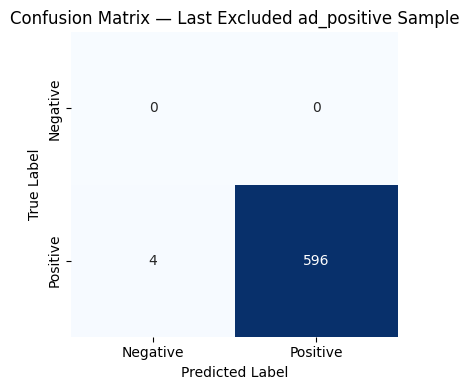

True Negatives : 0
False Positives: 0
False Negatives: 4
True Positives : 596


In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------
# Force both labels (0 = Negative, 1 = Positive)
# -------------------------------------------------
cm = confusion_matrix(
    y_true,
    y_preds,
    labels=[0, 1]
)

# -------------------------------------------------
# Plot confusion matrix
# -------------------------------------------------
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
    cbar=False
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Last Excluded ad_positive Sample")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Optional: print readable breakdown
# -------------------------------------------------
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives : {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives : {tp}")


In [52]:
# %% Step 11 - Gradient-based saliency scores (for your unseen trial segments)

import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# ✅ Your electrode list (must match channel order in X_test_norm)
electrode_names = [
    'Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2',
    'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz',
    'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2',
    'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'F9', 'AFF1h', 'FFC1h', 'FFC5h', 'FTT7h',
    'FCC3h', 'CCP1h', 'CCP5h', 'TPP7h', 'P9', 'PPO9h', 'PO9', 'O9', 'OI1h', 'PPO1h', 'CPP3h', 'CPP4h', 'PPO2h', 'OI2h',
    'O10', 'PO10', 'PPO10h', 'P10', 'TPP8h', 'CCP6h', 'CCP2h', 'FCC4h', 'FTT8h', 'FFC6h', 'FFC2h', 'AFF2h', 'F10',
    'AFp1', 'AFF5h', 'FFT9h', 'FFT7h', 'FFC3h', 'FCC1h', 'FCC5h', 'FTT9h', 'TTP7h', 'CCP3h', 'CPP1h', 'CPP5h', 'TPP9h',
    'POO9h', 'PPO5h', 'POO1', 'POO2', 'PPO6h', 'POO10h', 'TPP10h', 'CPP6h', 'CPP2h', 'CCP4h', 'TTP8h', 'FTT10h',
    'FCC6h', 'FCC2h', 'FFC4h', 'FFT8h', 'FFT10h', 'AFF6h', 'AFp2'
]

# --- Safety check: electrode count must match your data channel count ---
n_channels_data = X_test_norm.shape[1]
if len(electrode_names) != n_channels_data:
    print(f"⚠️ Electrode list length = {len(electrode_names)} but X_test_norm has {n_channels_data} channels.")
    # Fallback: auto-generate names to avoid crashing (or trim if electrode list is longer)
    if len(electrode_names) > n_channels_data:
        electrode_names = electrode_names[:n_channels_data]
        print(f"✅ Trimmed electrode list to {n_channels_data}.")
    else:
        electrode_names = [f"EEG{i+1}" for i in range(n_channels_data)]
        print(f"✅ Using auto-generated names EEG1..EEG{n_channels_data}.")

def compute_electrode_saliency(model, input_sample, class_index=1):
    """
    Compute per-electrode saliency for ONE sample shaped like (1, C, T, 1).
    Works for sigmoid (1 output) or softmax (>=2 outputs).
    """
    input_sample = tf.convert_to_tensor(input_sample, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_sample)
        pred = model(input_sample, training=False)

        # Make a scalar target to differentiate
        if pred.shape[-1] == 1:
            target = pred[:, 0]                          # sigmoid probability
        else:
            target = pred[:, class_index]                # softmax probability for class_index

    grads = tape.gradient(target, input_sample)          # same shape as input_sample
    grads = tf.abs(grads)

    # Average over time and "channel dimension" (the last dim=1) -> keep electrodes
    # input shape: (1, C, T, 1) => reduce over T and last dim
    saliency = tf.reduce_mean(grads, axis=(2, 3))        # -> (1, C)
    return saliency.numpy().flatten()

# Compute saliency for each segment in your unseen trial
all_saliencies = []
for i in tqdm(range(X_test_norm.shape[0]), desc="Computing Saliency (segments)"):
    sample = X_test_norm[i:i+1]                          # (1, C, T, 1)
    sal = compute_electrode_saliency(model, sample, class_index=1)
    all_saliencies.append(sal)

all_saliencies = np.array(all_saliencies, dtype=np.float32)   # (n_segments, C)

# Aggregate across segments
mean_saliency = np.mean(all_saliencies, axis=0)               # (C,)
normalized_saliency = mean_saliency / (np.max(mean_saliency) + 1e-8)

# Save CSV
saliency_df = pd.DataFrame({
    "Electrode": electrode_names,
    "Saliency Score": normalized_saliency
})

out_csv = "gradient_saliency_scores_last_excluded_ad_positive_trial.csv"
saliency_df.to_csv(out_csv, index=False)
print(f"✅ Saved gradient-based saliency scores to '{out_csv}'")


⚠️ Electrode list length = 127 but X_test_norm has 62 channels.
✅ Trimmed electrode list to 62.


Computing Saliency (segments):  20%|██        | 122/600 [00:12<00:48,  9.77it/s]


KeyboardInterrupt: 

In [ ]:
# %% [NEW CELL] Clear topomap: BIG dots + labels with leader lines (robust for your channel set)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne

# -------- 1) Load values --------
if "normalized_saliency" in globals() and "electrode_names" in globals():
    ch_names_orig = list(electrode_names)
    values_orig = np.asarray(normalized_saliency, dtype=float)
else:
    # Change filename if needed
    df = pd.read_csv("70th_gradient_saliency_scores.csv")
    ch_names_orig = df["Electrode"].astype(str).tolist()
    values_orig = df["Saliency Score"].to_numpy(dtype=float)

# -------- 2) Build mapping to montage channel names --------
# Many high-density names end with "h" (e.g., AFF1h). Standard montages often store them without "h".
def montage_lookup_name(name: str) -> str:
    n = name.strip()
    if n.endswith("h") and len(n) > 1:
        return n[:-1]  # AFF1h -> AFF1
    return n

ch_names_lookup = [montage_lookup_name(n) for n in ch_names_orig]

# -------- 3) Create info & set a montage with custom positions --------
# Use standard_1005 for broader coverage than standard_1020
base_montage = mne.channels.make_standard_montage("standard_1005")
base_pos = base_montage.get_positions()["ch_pos"]  # dict: {name: xyz}

# Create a custom position dict for *your original* channel names
# by borrowing xyz from the lookup name if available.
ch_pos_custom = {}
keep_idx = []
for i, (orig, look) in enumerate(zip(ch_names_orig, ch_names_lookup)):
    if look in base_pos:
        ch_pos_custom[orig] = base_pos[look]
        keep_idx.append(i)

if len(keep_idx) == 0:
    raise RuntimeError(
        "No channels matched the montage. Try a different montage (e.g., 'biosemi160') "
        "or provide a custom electrode position file."
    )

# Keep only channels we can place
ch_names = [ch_names_orig[i] for i in keep_idx]
values = values_orig[keep_idx]

# Create info and apply custom dig montage
info = mne.create_info(ch_names=ch_names, sfreq=1000.0, ch_types="eeg")
custom_montage = mne.channels.make_dig_montage(ch_pos=ch_pos_custom, coord_frame="head")
info.set_montage(custom_montage, on_missing="ignore")

# -------- 4) Compute 2D topomap coordinates (only valid channels exist here) --------
coords2d = mne.channels.layout._find_topomap_coords(info, picks=np.arange(len(ch_names)))

# -------- 5) Plot BIG + crisp --------
fig, ax = plt.subplots(figsize=(14, 9), dpi=250)

vmin, vmax = float(values.min()), float(values.max())  # or set fixed range manually

im, cn = mne.viz.plot_topomap(
    values,
    info,
    axes=ax,
    show=False,
    contours=6,
    sensors=False,      # draw our own dots
    outlines="head",
    vlim=(vmin, vmax),
    cmap="jet",
)

# -------- 6) Draw big dots + labels with outward leader lines --------
dot_size = 18
font_size = 13
arrow_lw = 0.9

for (x, y), name in zip(coords2d, ch_names):
    # big dot
    ax.plot(x, y, "k.", markersize=dot_size, zorder=10)

    # radial outward label placement
    r = np.sqrt(x * x + y * y) + 1e-9
    ux, uy = x / r, y / r  # outward unit vector

    # base offset outward + a tiny vertical lift to reduce overlap
    offset_out = 0.085
    offset_lift = 0.015

    x_text = x + ux * offset_out
    y_text = y + uy * offset_out + (offset_lift if y >= 0 else -offset_lift)

    ax.annotate(
        name,
        xy=(x, y),
        xytext=(x_text, y_text),
        textcoords="data",
        fontsize=font_size,
        fontweight="bold",
        ha="left" if x_text >= x else "right",
        va="center",
        bbox=dict(facecolor="white", edgecolor="black", alpha=0.88, pad=0.25),
        arrowprops=dict(arrowstyle="-", color="black", lw=arrow_lw),
        zorder=11,
    )

# -------- 7) Colorbar + title --------
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Electrode importance", fontsize=14)
cbar.ax.tick_params(labelsize=12)

missing = len(ch_names_orig) - len(ch_names)
ax.set_title(
    f"Topographic map of electrode importance (clear labels)\n"
    f"Plotted {len(ch_names)} channels (skipped {missing} without montage positions)",
    fontsize=18,
)

ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
# %% CELL 9B — Calculate Average Probability (Production-Style)

"""
This matches the production code calculation:
1. Get sigmoid probabilities per segment
2. Average across all segments
3. Determine class and confidence
"""

# Get raw probabilities (already computed in Cell 9)
# y_probs is shape (n_segments, 1) - sigmoid output per segment

# Calculate average probability across all segments
avg_probability = float(np.mean(y_probs))

# Determine predicted class using 0.5 threshold
predicted_class = "positive" if avg_probability >= 0.5 else "negative"

# Calculate confidence (production logic)
if avg_probability >= 0.5:
    confidence = avg_probability
else:
    confidence = 1.0 - avg_probability

# Display results
print("="*60)
print("PRODUCTION-STYLE PROBABILITY CALCULATION")
print("="*60)
print(f"Total segments analyzed: {len(y_probs)}")
print(f"Average sigmoid probability: {avg_probability:.6f}")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.3f}")
print("="*60)

# Breakdown statistics
print("\nSegment Probability Statistics:")
print(f"  Min probability: {y_probs.min():.6f}")
print(f"  Max probability: {y_probs.max():.6f}")
print(f"  Median probability: {np.median(y_probs):.6f}")
print(f"  Std dev: {y_probs.std():.6f}")

# Distribution of predictions
num_positive_segments = (y_probs >= 0.5).sum()
num_negative_segments = (y_probs < 0.5).sum()
print(f"\nSegment-level predictions:")
print(f"  Positive segments: {num_positive_segments} ({100*num_positive_segments/len(y_probs):.1f}%)")
print(f"  Negative segments: {num_negative_segments} ({100*num_negative_segments/len(y_probs):.1f}%)")

# Expected output format (matches production)
output_json = {
    "status": predicted_class,
    "confidence": round(confidence, 3),
    "probability": round(avg_probability, 3),
    "metadata": {
        "total_segments": len(y_probs),
        "positive_segments": int(num_positive_segments),
        "negative_segments": int(num_negative_segments),
        "ground_truth": "positive" if y_test_trial == 1 else "negative"
    }
}

print("\n" + "="*60)
print("PRODUCTION OUTPUT FORMAT:")
print("="*60)
import json
print(json.dumps(output_json, indent=2))